tutorial from 
https://www.youtube.com/watch?v=K0lWSB2QoIQ&ab_channel=PatrickLoeber

For those new to transfer learning: ideally we would like to freeze all of the layers other than the newly added head layer, and train for n epochs, then unfreeze the preceding layers, and train the entire network using a sliced learning rate, where the parameters of the later layers are updated faster than the parameters of the earlier layers. This is how libraries like fastai handle transfer learning out of the box.

ML core workflow 

1. data (input)
- do some data visualisation
2. model (function)
3. loss and metrics (evaluationn of output)
- classification or regression
- c: loss: e.g. CrossEntropyLoss (this is for single correct answer), care about right or wrong, thats classification,
    - usually use CrossEntropyLoss instead of BCE
- c: metric: accuracy, precision and recall (when dataset classes are imbalanced), MAE, f1 score etc.
- r: MSE, this type, care about absolute values
4. optimizer (update weights)

# full workflow - model3 resnet18 pretrained 

1. imports
2. dataset class
-len, init: get the fnames
-make it generic, train,val,test diff by adding train val test to root path
-set encoder and decoder for classes
-getitem open image, convert rgb, get labels and use encoder to get class int
-return as X,y

3. define transforms for train val test
-for train, ToTensor,Resize,other tfms,Normalze
-for val test, ToTensor,Resize,Normalize

4. initialise train val test data and dataloader
-assert os.path.exists train val test paths to checl
-train_dl shuffle=True,drop_last=True
-val_dl shuffle=False,drop_last=True

5. plot images to visualise
-for batch in train_dl, images,labels=batch, need img.numpy().transpose(1,2,0)

6. create model
-custom model, need do super().__init__()
-abstract repetitions like Convolutions into seperate ConvModule
-initialise model
-test forward pass of model using sample image

7. loss and optimizers
-initialise criterion, usually nn.CrossEntropyLoss()
-initialise lr
-initialise optimizer, usually torch.optim.Adam(model.parameters(),lr=lr)
-test out if outputs of forward pass works with loss function

8. def get_accuracy function and initialise device and model.to(device)
-test out accuracy function and see if output makes sense
-can initialise own numpy array to test, correct shapes etc

9. training and validation loops
-initialise trg and val logs for loss and acc
-print statements
-track time
-training loop:
    reshape labels, shape depends on what input the loss function needs, diff loss require diff shapes, 0D,1D,2D
    to(device)
    forward pass
    calc loss, store in logs
    calc acc, store in logs
    zero optimizer gradients
    calc gradients of loss fn
    update weights of optimizer
-validation loop:
    reshape labels
    to(device)
    forward pass
    calc loss, store in logs
    calc acc, store in logs
-print results
print_divisor=1/(training_steps_to_print+1)
if i%int(len(train_dl)*print_divisor)==0:
    if i==0 or i==len(train_dl)-1:
        continue
    else:
        print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")
-save best model
best_accuracy = 0.0
...
Inside the training loop
...
Calculate validation accuracy
validation_accuracy = calculate_accuracy(model1, validation_data)
Check if the current model has the highest validation accuracy
if validation_accuracy > best_accuracy:
    best_accuracy = validation_accuracy
    torch.save(model1.state_dict(), save_path)
...

10. plot results of train and val logs for loss and acc
11. make predictions on test, only need outputs=forward pass and predictions
-need to convert wtv in gpu to cpu first

In [146]:
# 1. imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torchvision.transforms as transforms

In [31]:
# 2. dataset class

# take input of root_path and transforms will suffice
# dont create specific modes for train or val, make the class generic
# separate train and val data by changing the root_path + train or + val 
# create class encoder and the reverse
# get files using os.walk
# organise data into X,y (image,encoded int label, 0 1, one hot do later in loop)

class Ants_Bees_Dataset(Dataset):
    def __init__(self,path,tfms=None):
        self.path=path
        assert os.path.exists(self.path) #if True, code continues, else error raised
        self.tfms=tfms
        
        self.file_names=[]
        for p,d,f in os.walk(self.path): #os.walk iterates through all possible path,dir,file even if path is nested, it goes to the lowest level
            #this ensures that all files are stored, f is a list of all files in given dir, so need to for loop f
            for file in f:
                self.file_names.append(os.path.join(p,file)) #in lowest level, there is no d since its already the lowest level folder and d is supposed to be subfolder
                    
        self.class_encoder={"ants":0,"bees":1}
        self.class_decoder={v:k for k,v in self.class_encoder.items()}
            
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self,i): #X is image, y is label
        image_path=self.file_names[i]
        X=Image.open(image_path) #image
        X=X.convert("RGB")
        y=image_path.split("\\")[-2] #label
            
        if self.tfms:
            X=self.tfms(X)
            
        y=self.class_encoder[y]
                               
        return X,y

In [32]:
# 3. define transforms for train val test
# define transforms

img_dim = 224
mean=np.array([0.5,0.5,0.5]) #3 values for RGB channels, grayscale images 1 value only
std=np.array([0.25,0.25,0.25])

def train_tfms():
    t=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_dim,img_dim)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation((-90,90)),
        transforms.Normalize(mean=mean,std=std)                                  
    ])
    return t

def val_tfms():
    t=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_dim,img_dim)),
        transforms.Normalize(mean=mean,std=std)
    ])
    return t

In [33]:
# 4. initialise train val test data and dataloader

# initialise train and val datasets and dataloaders

batch_size=4
root_path="C:/Users/Palaash.HPZ/Downloads/hymenoptera_data"
train_path=os.path.join(root_path,"train")
val_path=os.path.join(root_path,"val")
assert os.path.exists(train_path)
assert os.path.exists(val_path)

train_data=Ants_Bees_Dataset(train_path,tfms=train_tfms())
val_data=Ants_Bees_Dataset(train_path,tfms=val_tfms())

train_dl=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

val_dl=DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

C:\Users\Palaash.HPZ\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

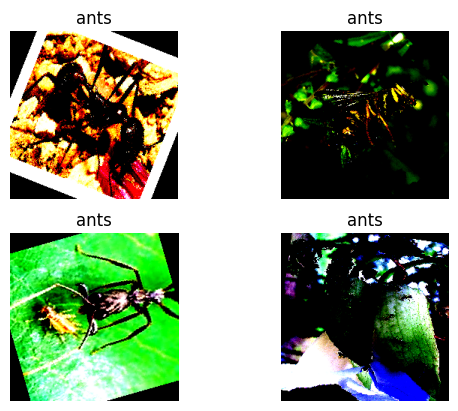

In [34]:
# 5. plot images to visualise
# plot some images - train

for batch in train_dl:
    images,labels=batch
    for i in range(len(images)):
        img=images[i].numpy()
        label=labels[i]
        img=img.transpose(1,2,0)
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.title(Ants_Bees_Dataset(root_path).class_decoder[label.item()])
        plt.axis("off")
    break
    
plt.show()

In [177]:
# 6. create model

# pretrained model
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

#example custom model
class ConvModule(nn.Module):
    def __init__(self,in_c,out_c,conv_kernel,pool_kernel,pool_stride):
        '''
        Inputs:
        in_c = number of input channels for the conv
        out_c = number of output channels for the conv
        conv_kernel = size of conv kernel, n x n
        pool_kernel = size of pool kernel, n x n
        pool_stride = int value of pooling stride
        
        Outputs:
        output of 1 full convolution block - conv, max pooling, ReLu activation function 

        Function:
        This class abstracts the convolution blocks in CNN-based models.
        '''
        super().__init__()
        self.conv=nn.Conv2d(in_c,out_c,conv_kernel)
        self.pool=nn.MaxPool2d(pool_kernel,pool_stride)
        
    def forward(self,x):
        return F.relu(self.pool(self.conv(x)))
    
class CustomModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=ConvModule(3,6,5,2,2)
        self.conv2=ConvModule(6,16,5,2,2)
        #to get the values for the feed forward layers, print output after conv2 first 
        self.fc1=nn.Linear(16*53*53,1024)
        self.fc2=nn.Linear(1024,128)
        self.fc3=nn.Linear(128,2) #2 output value since using CrossEntropyLoss
#         self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(-1,16*53*53) #flatten
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
#         x=self.softmax(x) #not needed because CrossEntropyloss implements softmax
        return x

In [184]:
# 7. loss and optimizers

lr=1e-4
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [185]:
# 8. def get_accuracy function and initialise device and model.to(device)

#accuracy function for softmax output
def get_accuracy(outputs, labels):
    _, predicted_classes = torch.max(outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    correct_predictions = (predicted_classes == labels).sum().item()
    accuracy = correct_predictions / labels.size(0) * 100
    return accuracy

# #acuracy function for sigmoid function
# def get_accuracy(outputs,labels): #accuracy function changes with task, this is for binary image classification
#     #get num_correct/num_labels
#     threshold=0.5
#     predicted_classes=[1 if pred>=threshold else 0 for pred in outputs] #after sigmoid function, output probabilities>=threshold is assigned class 1, else 0
#     correct_predictions=[1 if predicted_classes[i]==labels[i] else 0 for i in range(len(outputs))]
#     n_correct=sum(correct_predictions) #will give number of ones inside since sum+0=sum
#     return n_correct/len(labels)*100

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

print(device)
print(model3)

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [179]:
# 9. training and validation loops

n_epochs=100
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

# best_accuracy = 0.0
# # ...

# # Inside the training loop
# # ...
# # Calculate validation accuracy
# validation_accuracy = calculate_accuracy(model1, validation_data)
# # Check if the current model has the highest validation accuracy
# if validation_accuracy > best_accuracy:
#     best_accuracy = validation_accuracy
#     torch.save(model1.state_dict(), save_path)
# # ...

# # load model
# # Load the saved model
# model_path="ants_bees_resnet18.pth"

# model = CustomModel()  # Instantiate the model
# model.load_state_dict(torch.load(model_path))

########## Start Training loop  ##########
------------------------------
Epoch 1/100


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2429455708.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 0.5511, training acc: 70.1613, time elapsed: 2.3154


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2429455708.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/100
training loss: 0.5336, training acc: 71.7213, validation loss: 1.0028, validation acc: 51.2295, time elapsed: 6.4787
------------------------------
Epoch 2/100
Step 31/61: training loss: 0.4387, training acc: 76.6129, time elapsed: 8.6103
End of epoch 2/100
training loss: 0.4487, training acc: 77.4590, validation loss: 0.9341, validation acc: 51.6393, time elapsed: 12.9502
------------------------------
Epoch 3/100
Step 31/61: training loss: 0.4060, training acc: 83.0645, time elapsed: 15.1545
End of epoch 3/100
training loss: 0.4312, training acc: 80.7377, validation loss: 0.8699, validation acc: 44.6721, time elapsed: 19.5109
------------------------------
Epoch 4/100
Step 31/61: training loss: 0.3432, training acc: 87.9032, time elapsed: 21.7208
End of epoch 4/100
training loss: 0.3301, training acc: 86.8852, validation loss: 1.0050, validation acc: 51.2295, time elapsed: 26.0368
------------------------------
Epoch 5/100
Step 31/61: training loss: 0.3908, trainin

Step 31/61: training loss: 0.2482, training acc: 91.9355, time elapsed: 219.6678
End of epoch 33/100
training loss: 0.2187, training acc: 91.8033, validation loss: 0.6739, validation acc: 67.2131, time elapsed: 223.8514
------------------------------
Epoch 34/100
Step 31/61: training loss: 0.0783, training acc: 97.5806, time elapsed: 226.0356
End of epoch 34/100
training loss: 0.1144, training acc: 95.4918, validation loss: 0.7575, validation acc: 63.5246, time elapsed: 230.5877
------------------------------
Epoch 35/100
Step 31/61: training loss: 0.1339, training acc: 95.1613, time elapsed: 232.9836
End of epoch 35/100
training loss: 0.1425, training acc: 94.6721, validation loss: 0.7744, validation acc: 64.3443, time elapsed: 237.7251
------------------------------
Epoch 36/100
Step 31/61: training loss: 0.1334, training acc: 95.9677, time elapsed: 240.1738
End of epoch 36/100
training loss: 0.1109, training acc: 96.3115, validation loss: 0.7161, validation acc: 68.8525, time elapse

End of epoch 64/100
training loss: 0.0655, training acc: 97.5410, validation loss: 0.5155, validation acc: 82.3770, time elapsed: 435.5532
------------------------------
Epoch 65/100
Step 31/61: training loss: 0.0520, training acc: 98.3871, time elapsed: 437.9600
End of epoch 65/100
training loss: 0.0757, training acc: 97.1311, validation loss: 0.4637, validation acc: 83.1967, time elapsed: 442.6274
------------------------------
Epoch 66/100
Step 31/61: training loss: 0.0369, training acc: 100.0000, time elapsed: 444.8072
End of epoch 66/100
training loss: 0.0527, training acc: 98.7705, validation loss: 0.4916, validation acc: 82.3770, time elapsed: 448.9385
------------------------------
Epoch 67/100
Step 31/61: training loss: 0.0397, training acc: 99.1935, time elapsed: 451.0432
End of epoch 67/100
training loss: 0.0878, training acc: 98.3607, validation loss: 0.4359, validation acc: 86.8852, time elapsed: 455.3550
------------------------------
Epoch 68/100
Step 31/61: training los

End of epoch 95/100
training loss: 0.0854, training acc: 97.5410, validation loss: 0.1873, validation acc: 93.0328, time elapsed: 644.9232
------------------------------
Epoch 96/100
Step 31/61: training loss: 0.0193, training acc: 100.0000, time elapsed: 647.3304
End of epoch 96/100
training loss: 0.0128, training acc: 100.0000, validation loss: 0.2714, validation acc: 92.6230, time elapsed: 652.0322
------------------------------
Epoch 97/100
Step 31/61: training loss: 0.0081, training acc: 100.0000, time elapsed: 654.2271
End of epoch 97/100
training loss: 0.0085, training acc: 100.0000, validation loss: 0.3481, validation acc: 89.7541, time elapsed: 658.3162
------------------------------
Epoch 98/100
Step 31/61: training loss: 0.0035, training acc: 100.0000, time elapsed: 660.5137
End of epoch 98/100
training loss: 0.0066, training acc: 100.0000, validation loss: 0.2715, validation acc: 91.3934, time elapsed: 664.6754
------------------------------
Epoch 99/100
Step 31/61: trainin

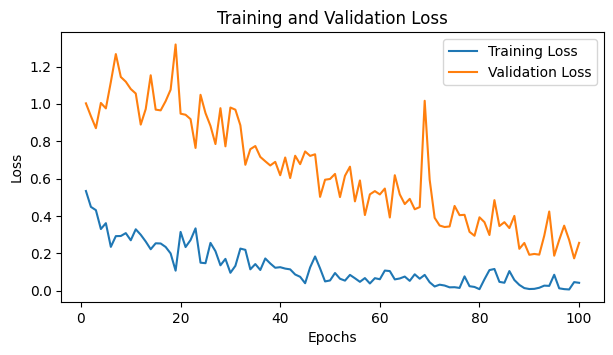

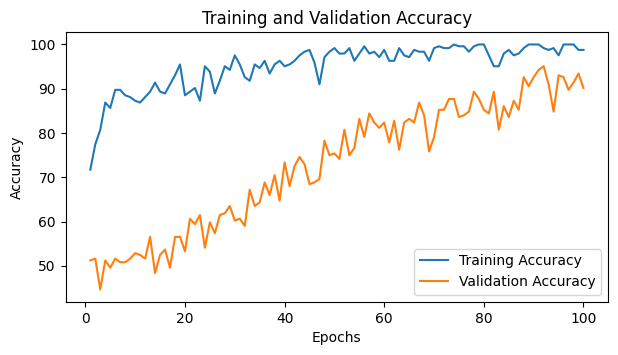

In [180]:
# 10. plot results of train and val logs for loss and acc

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\1176354142.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


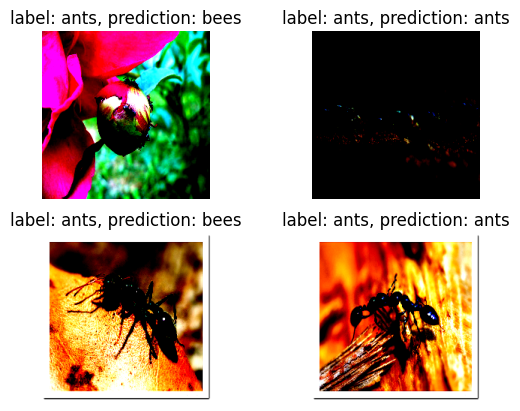

In [183]:
# 11. make predictions on test, only need outputs=forward pass and predictions

index=9

class_decoder = train_data=Ants_Bees_Dataset(train_path,tfms=train_tfms()).class_decoder
for i,(images,labels) in enumerate(val_dl):
    # to device and reshape labels
    labels=labels.reshape((-1,1)).float()
    images=images.to(device)
    labels=labels.to(device)
    # forward pass
    outputs=model3(images)
    softmax_outputs=nn.Softmax()(outputs)
    _, predicted_classes = torch.max(softmax_outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    predicted_class=[class_decoder[x.item()] for x in predicted_classes.cpu()]
    gt_class=[class_decoder[x.item()] for x in labels.cpu()]
    if i==index:
        break


for i in range(len(images)):
    plt.subplot(len(images)//2,len(images)//2,i+1)
    img=images[i]
    img=img.cpu().numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"label: {gt_class[i]}, prediction: {predicted_class[i]}")
    plt.axis("off")
    
    
plt.show()

# model1: custom CNN model + BCELoss()

n_classes=1 since using BCELoss > Sigmoid() since binary

 In PyTorch, the torch.nn.CrossEntropyLoss function applies the softmax function internally as part of its computation. This means that you don't need to explicitly apply the softmax activation to the output of your model when using CrossEntropyLoss.

On the other hand, if you're using binary cross-entropy loss (torch.nn.BCELoss), you need to apply the sigmoid activation function to the model's output. The sigmoid function maps the output values to the range [0, 1], which is necessary for binary classification.

In [35]:
class ConvModule(nn.Module):
    def __init__(self,in_c,out_c,conv_kernel,pool_kernel,pool_stride):
        '''
        Inputs:
        in_c = number of input channels for the conv
        out_c = number of output channels for the conv
        conv_kernel = size of conv kernel, n x n
        pool_kernel = size of pool kernel, n x n
        pool_stride = int value of pooling stride
        
        Outputs:
        output of 1 full convolution block - conv, max pooling, ReLu activation function 

        Function:
        This class abstracts the convolution blocks in CNN-based models.
        '''
        super().__init__()
        self.conv=nn.Conv2d(in_c,out_c,conv_kernel)
        self.pool=nn.MaxPool2d(pool_kernel,pool_stride)
        
    def forward(self,x):
        return F.relu(self.pool(self.conv(x)))
    
class CustomModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=ConvModule(3,6,5,2,2)
        self.conv2=ConvModule(6,16,5,2,2)
        #to get the values for the feed forward layers, print output after conv2 first 
        self.fc1=nn.Linear(16*53*53,1024)
        self.fc2=nn.Linear(1024,128)
        self.fc3=nn.Linear(128,1) #1 output value since using BCEloss
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(-1,16*53*53) #flatten
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.sigmoid(x)
        return x

In [36]:
lr=1e-3
model1=CustomModel1()
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=lr)

def get_accuracy(outputs,labels): #accuracy function changes with task, this is for binary image classification
    #get num_correct/num_labels
    threshold=0.5
    predicted_classes=[1 if pred>=threshold else 0 for pred in outputs] #after sigmoid function, output probabilities>=threshold is assigned class 1, else 0
    correct_predictions=[1 if predicted_classes[i]==labels[i] else 0 for i in range(len(outputs))]
    n_correct=sum(correct_predictions) #will give number of ones inside since sum+0=sum
    return n_correct/len(labels)*100

In [46]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1=model1.to(device)

print(device)
print(model1)
#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

cuda
CustomModel1(
  (conv1): ConvModule(
    (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvModule(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [47]:
#training and val loop

n_epochs=100
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
        labels=labels.reshape((-1,1))
        images=images.to(device)
        labels=labels.to(device).float()
        # forward pass
        outputs=model1.forward(images)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
        labels=labels.reshape((-1,1)).float()
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model1(images)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/100
Step 31/61: training loss: 51.6129, training acc: 48.3871, time elapsed: 2.3272
End of epoch 1/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 6.0720
------------------------------
Epoch 2/100
Step 31/61: training loss: 47.5806, training acc: 52.4194, time elapsed: 7.9721
End of epoch 2/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 11.6644
------------------------------
Epoch 3/100
Step 31/61: training loss: 49.1935, training acc: 50.8065, time elapsed: 13.6449
End of epoch 3/100
training loss: 50.4098, training acc: 49.5902, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 17.3773
------------------------------
Epoch 4/100
Step 31/61: training loss: 53.2258, training acc: 46.7742, time elapsed: 19.3703
End of epoch 4/100
training loss: 50.4098, trai

Step 31/61: training loss: 51.6129, training acc: 48.3871, time elapsed: 194.9826
End of epoch 32/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 199.1368
------------------------------
Epoch 33/100
Step 31/61: training loss: 48.3871, training acc: 51.6129, time elapsed: 201.3808
End of epoch 33/100
training loss: 50.4098, training acc: 49.5902, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 205.5898
------------------------------
Epoch 34/100
Step 31/61: training loss: 50.0000, training acc: 50.0000, time elapsed: 207.5796
End of epoch 34/100
training loss: 50.4098, training acc: 49.5902, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 211.6229
------------------------------
Epoch 35/100
Step 31/61: training loss: 48.3871, training acc: 51.6129, time elapsed: 213.8187
End of epoch 35/100
training loss: 50.4098, training acc: 49.5902, validation loss: 50.8197, validation acc: 49.1803,

Step 31/61: training loss: 55.6452, training acc: 44.3548, time elapsed: 395.4115
End of epoch 63/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 399.7780
------------------------------
Epoch 64/100
Step 31/61: training loss: 50.8065, training acc: 49.1935, time elapsed: 402.0575
End of epoch 64/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 406.4554
------------------------------
Epoch 65/100
Step 31/61: training loss: 52.4194, training acc: 47.5806, time elapsed: 408.8307
End of epoch 65/100
training loss: 50.4098, training acc: 49.5902, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 413.2233
------------------------------
Epoch 66/100
Step 31/61: training loss: 53.2258, training acc: 46.7742, time elapsed: 415.5952
End of epoch 66/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803,

Step 31/61: training loss: 55.6452, training acc: 44.3548, time elapsed: 596.7864
End of epoch 94/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 600.8634
------------------------------
Epoch 95/100
Step 31/61: training loss: 50.0000, training acc: 50.0000, time elapsed: 603.0867
End of epoch 95/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 607.3682
------------------------------
Epoch 96/100
Step 31/61: training loss: 50.0000, training acc: 50.0000, time elapsed: 609.6629
End of epoch 96/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803, time elapsed: 613.8947
------------------------------
Epoch 97/100
Step 31/61: training loss: 56.4516, training acc: 43.5484, time elapsed: 616.1441
End of epoch 97/100
training loss: 50.8197, training acc: 49.1803, validation loss: 50.8197, validation acc: 49.1803,

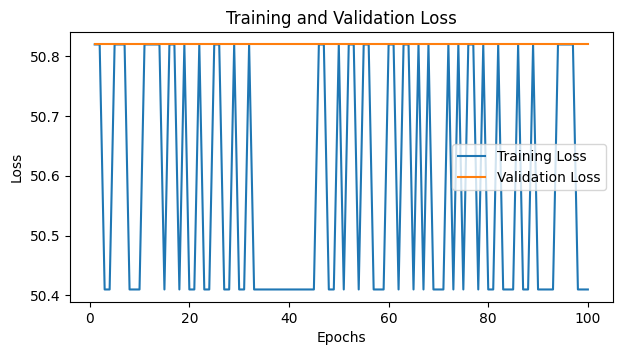

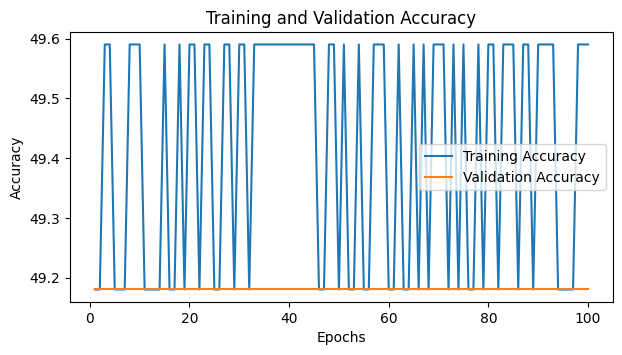

In [49]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# save model
save_path="ants_bees_cnn_model1.pth"
torch.save(model1.state_dict(),save_path)

The line torch.save(model1.state_dict(), save_path) saves the state dictionary of the model to the specified save_path. The state dictionary includes all the learnable parameters of the model.

By default, this line of code saves the latest state of the model at the time it is called. If you want to save the best model based on a certain criterion (e.g., highest validation accuracy), you need to implement the logic for tracking the best model and save the state dictionary accordingly.

Here's an example 

In [ ]:
# best_accuracy = 0.0
# # ...

# # Inside the training loop
# # ...
# # Calculate validation accuracy
# validation_accuracy = calculate_accuracy(model1, validation_data)
# # Check if the current model has the highest validation accuracy
# if validation_accuracy > best_accuracy:
#     best_accuracy = validation_accuracy
#     torch.save(model1.state_dict(), save_path)
# # ...

In [ ]:
# # load model
# # Load the saved model
# model_path="ants_bees_resnet18.pth"

# model = CustomModel()  # Instantiate the model
# model.load_state_dict(torch.load(model_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


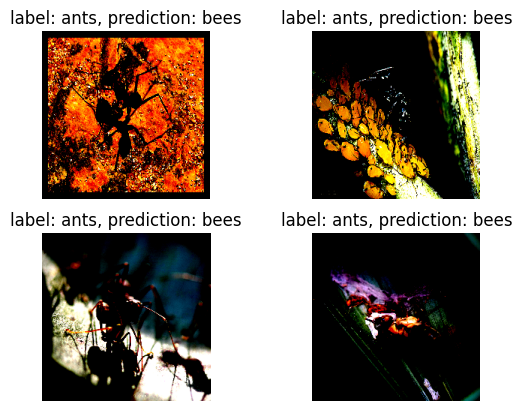

In [56]:
# make predictions

index=10

class_decoder = train_data=Ants_Bees_Dataset(train_path,tfms=train_tfms()).class_decoder
for i,(images,labels) in enumerate(val_dl):
    # to device and reshape labels
    labels=labels.reshape((-1,1)).float()
    images=images.to(device)
    labels=labels.to(device)
    # forward pass
    outputs=model1(images)
    predictions=[1 if x>=0.5 else 0 for x in outputs]
    predicted_class=[class_decoder[x] for x in predictions]
    gt_class=[class_decoder[x.item()] for x in labels.cpu()]
    if i==index:
        break


for i in range(len(images)):
    plt.subplot(len(images)//2,len(images)//2,i+1)
    img=images[i]
    img=img.cpu().numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"label: {gt_class[i]}, prediction: {predicted_class[i]}")
    plt.axis("off")
    
    
plt.show()

# model2: custom CNN model + CrossEntropyLoss()

It seems that the error is caused by the data type mismatch between the model outputs and the labels. In your code, you are converting the labels to float using labels=labels.to(device).float(), but the criterion you are using (nn.CrossEntropyLoss) expects the labels to be of type long (integer).

To fix this issue, you need to ensure that the labels are of type long when calculating the loss. You can remove the .float() conversion for the labels in both the training and validation loops. Here's the updated code:

for nn.BCELoss need to do labels.to(device).float() since expected float 
for nn.CrossEntropyLoos just do labels.to(device) since expected long

In [125]:
class ConvModule(nn.Module):
    def __init__(self,in_c,out_c,conv_kernel,pool_kernel,pool_stride):
        '''
        Inputs:
        in_c = number of input channels for the conv
        out_c = number of output channels for the conv
        conv_kernel = size of conv kernel, n x n
        pool_kernel = size of pool kernel, n x n
        pool_stride = int value of pooling stride
        
        Outputs:
        output of 1 full convolution block - conv, max pooling, ReLu activation function 

        Function:
        This class abstracts the convolution blocks in CNN-based models.
        '''
        super().__init__()
        self.conv=nn.Conv2d(in_c,out_c,conv_kernel)
        self.pool=nn.MaxPool2d(pool_kernel,pool_stride)
        
    def forward(self,x):
        return F.relu(self.pool(self.conv(x)))
    
class CustomModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=ConvModule(3,6,5,2,2)
        self.conv2=ConvModule(6,16,5,2,2)
        #to get the values for the feed forward layers, print output after conv2 first 
        self.fc1=nn.Linear(16*53*53,1024)
        self.fc2=nn.Linear(1024,128)
        self.fc3=nn.Linear(128,2) #2 output value since using CrossEntropyLoss
#         self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(-1,16*53*53) #flatten
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
#         x=self.softmax(x) #not needed because CrossEntropyloss implements softmax
        return x

In [126]:
lr=1e-3
model2=CustomModel2()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model2.parameters(),lr=lr)

def get_accuracy(outputs, labels):
    _, predicted_classes = torch.max(outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    correct_predictions = (predicted_classes == labels).sum().item()
    accuracy = correct_predictions / labels.size(0) * 100
    return accuracy

In [127]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2=model2.to(device)

print(device)
print(model2)
#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

cuda
CustomModel2(
  (conv1): ConvModule(
    (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvModule(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [133]:
labels

tensor([1., 1., 1., 1.], device='cuda:0')

In [137]:
#training and val loop

n_epochs=100
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model2.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model2(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/100


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\1754277936.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 0.6925, training acc: 42.7419, time elapsed: 2.1677


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\1754277936.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/100
training loss: 0.6856, training acc: 51.2295, validation loss: 0.6736, validation acc: 56.5574, time elapsed: 6.0977
------------------------------
Epoch 2/100
Step 31/61: training loss: 0.6584, training acc: 54.8387, time elapsed: 8.0920
End of epoch 2/100
training loss: 0.6721, training acc: 54.9180, validation loss: 0.6648, validation acc: 55.3279, time elapsed: 11.9734
------------------------------
Epoch 3/100
Step 31/61: training loss: 0.6825, training acc: 50.8065, time elapsed: 14.0505
End of epoch 3/100
training loss: 0.6688, training acc: 54.0984, validation loss: 0.6561, validation acc: 58.1967, time elapsed: 17.9744
------------------------------
Epoch 4/100
Step 31/61: training loss: 0.6316, training acc: 69.3548, time elapsed: 20.0343
End of epoch 4/100
training loss: 0.6558, training acc: 64.3443, validation loss: 0.6595, validation acc: 56.5574, time elapsed: 24.2385
------------------------------
Epoch 5/100
Step 31/61: training loss: 0.6630, trainin

Step 31/61: training loss: 0.5587, training acc: 66.1290, time elapsed: 211.1824
End of epoch 33/100
training loss: 0.5716, training acc: 65.5738, validation loss: 0.5519, validation acc: 71.3115, time elapsed: 215.4854
------------------------------
Epoch 34/100
Step 31/61: training loss: 0.5804, training acc: 62.9032, time elapsed: 217.8442
End of epoch 34/100
training loss: 0.5661, training acc: 66.3934, validation loss: 0.5334, validation acc: 67.2131, time elapsed: 222.1354
------------------------------
Epoch 35/100
Step 31/61: training loss: 0.5175, training acc: 74.1935, time elapsed: 224.3972
End of epoch 35/100
training loss: 0.5323, training acc: 69.2623, validation loss: 0.5063, validation acc: 70.9016, time elapsed: 228.6812
------------------------------
Epoch 36/100
Step 31/61: training loss: 0.5435, training acc: 65.3226, time elapsed: 230.9749
End of epoch 36/100
training loss: 0.5450, training acc: 67.2131, validation loss: 0.5161, validation acc: 72.5410, time elapse

End of epoch 64/100
training loss: 0.5273, training acc: 71.3115, validation loss: 0.4596, validation acc: 75.0000, time elapsed: 418.1304
------------------------------
Epoch 65/100
Step 31/61: training loss: 0.4456, training acc: 74.1935, time elapsed: 420.3719
End of epoch 65/100
training loss: 0.4961, training acc: 70.4918, validation loss: 0.4610, validation acc: 76.6393, time elapsed: 424.4601
------------------------------
Epoch 66/100
Step 31/61: training loss: 0.4464, training acc: 77.4194, time elapsed: 426.6536
End of epoch 66/100
training loss: 0.4802, training acc: 72.9508, validation loss: 0.4734, validation acc: 78.2787, time elapsed: 430.8738
------------------------------
Epoch 67/100
Step 31/61: training loss: 0.4703, training acc: 73.3871, time elapsed: 433.0790
End of epoch 67/100
training loss: 0.5043, training acc: 72.5410, validation loss: 0.4739, validation acc: 79.5082, time elapsed: 437.3262
------------------------------
Epoch 68/100
Step 31/61: training loss

Step 31/61: training loss: 0.4921, training acc: 79.8387, time elapsed: 623.2121
End of epoch 96/100
training loss: 0.4541, training acc: 79.5082, validation loss: 0.6392, validation acc: 79.9180, time elapsed: 627.6145
------------------------------
Epoch 97/100
Step 31/61: training loss: 0.5643, training acc: 72.5806, time elapsed: 629.7087
End of epoch 97/100
training loss: 0.5186, training acc: 72.5410, validation loss: 0.4012, validation acc: 78.2787, time elapsed: 633.7213
------------------------------
Epoch 98/100
Step 31/61: training loss: 0.4866, training acc: 78.2258, time elapsed: 635.9017
End of epoch 98/100
training loss: 0.4775, training acc: 77.0492, validation loss: 0.3772, validation acc: 79.9180, time elapsed: 640.1233
------------------------------
Epoch 99/100
Step 31/61: training loss: 0.3917, training acc: 82.2581, time elapsed: 642.4199
End of epoch 99/100
training loss: 0.4065, training acc: 80.7377, validation loss: 0.4031, validation acc: 83.6066, time elapse

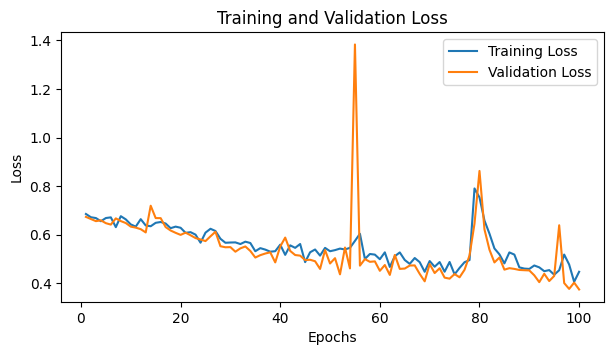

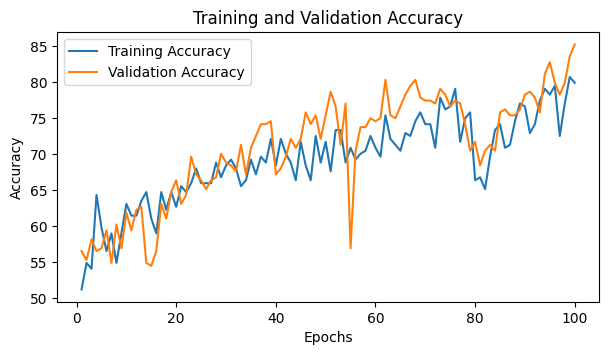

In [138]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [139]:
# save model
save_path="ants_bees_cnn_model2.pth"
torch.save(model2.state_dict(),save_path)

The line torch.save(model1.state_dict(), save_path) saves the state dictionary of the model to the specified save_path. The state dictionary includes all the learnable parameters of the model.

By default, this line of code saves the latest state of the model at the time it is called. If you want to save the best model based on a certain criterion (e.g., highest validation accuracy), you need to implement the logic for tracking the best model and save the state dictionary accordingly.

Here's an example 

In [ ]:
# best_accuracy = 0.0
# # ...

# # Inside the training loop
# # ...
# # Calculate validation accuracy
# validation_accuracy = calculate_accuracy(model1, validation_data)
# # Check if the current model has the highest validation accuracy
# if validation_accuracy > best_accuracy:
#     best_accuracy = validation_accuracy
#     torch.save(model1.state_dict(), save_path)
# # ...

In [ ]:
# # load model
# # Load the saved model
# model_path="ants_bees_resnet18.pth"

# model = CustomModel()  # Instantiate the model
# model.load_state_dict(torch.load(model_path))

C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\3105108399.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


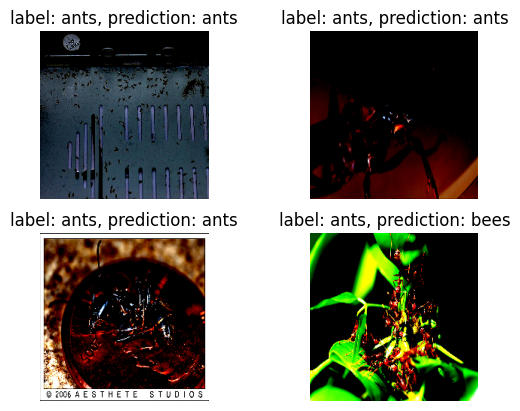

In [145]:
# make predictions

index=15

class_decoder = train_data=Ants_Bees_Dataset(train_path,tfms=train_tfms()).class_decoder
for i,(images,labels) in enumerate(val_dl):
    # to device and reshape labels
    labels=labels.reshape((-1,1)).float()
    images=images.to(device)
    labels=labels.to(device)
    # forward pass
    outputs=model2(images)
    softmax_outputs=nn.Softmax()(outputs)
    _, predicted_classes = torch.max(softmax_outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    predicted_class=[class_decoder[x.item()] for x in predicted_classes.cpu()]
    gt_class=[class_decoder[x.item()] for x in labels.cpu()]
    if i==index:
        break


for i in range(len(images)):
    plt.subplot(len(images)//2,len(images)//2,i+1)
    img=images[i]
    img=img.cpu().numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"label: {gt_class[i]}, prediction: {predicted_class[i]}")
    plt.axis("off")
    
    
plt.show()

# model3: pretrained resnet18 + CrossEntropyLoss()

In [159]:
def get_accuracy(outputs, labels):
    _, predicted_classes = torch.max(outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    correct_predictions = (predicted_classes == labels).sum().item()
    accuracy = correct_predictions / labels.size(0) * 100
    return accuracy

## lr = 1e-3

In [158]:
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

lr=1e-3
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [160]:
#
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

# print(device)
# print(model3)

#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [161]:
#training and val loop

n_epochs=10
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/10


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 1.3965, training acc: 57.2581, time elapsed: 2.8119


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/10
training loss: 1.0585, training acc: 58.1967, validation loss: 0.7627, validation acc: 50.4098, time elapsed: 6.9730
------------------------------
Epoch 2/10
Step 31/61: training loss: 0.6607, training acc: 68.5484, time elapsed: 9.1632
End of epoch 2/10
training loss: 0.6705, training acc: 64.3443, validation loss: 0.8163, validation acc: 51.6393, time elapsed: 13.4799
------------------------------
Epoch 3/10
Step 31/61: training loss: 0.6486, training acc: 66.1290, time elapsed: 15.8130
End of epoch 3/10
training loss: 0.6894, training acc: 65.1639, validation loss: 0.8058, validation acc: 50.4098, time elapsed: 20.0484
------------------------------
Epoch 4/10
Step 31/61: training loss: 0.6802, training acc: 58.8710, time elapsed: 22.3045
End of epoch 4/10
training loss: 0.6766, training acc: 63.1148, validation loss: 0.8741, validation acc: 51.6393, time elapsed: 26.5955
------------------------------
Epoch 5/10
Step 31/61: training loss: 0.6896, training acc: 6

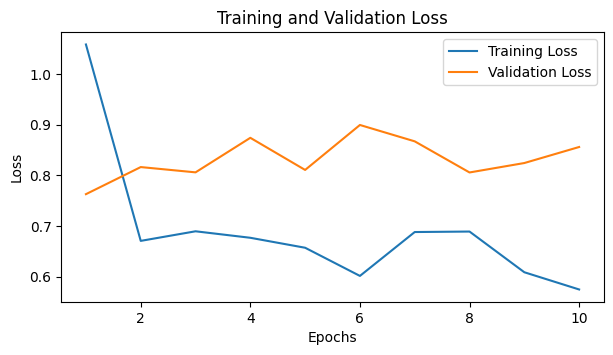

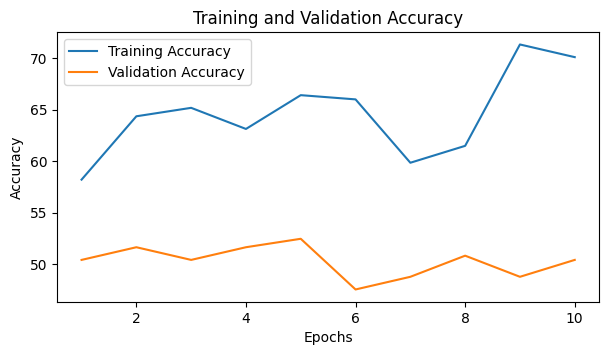

In [162]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## lr = 7.5e-4

In [163]:
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

lr=7.5e-4
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [164]:
#
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

# print(device)
# print(model3)

#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

In [165]:
#training and val loop

n_epochs=10
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/10


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 0.9746, training acc: 66.9355, time elapsed: 2.2691


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/10
training loss: 0.8616, training acc: 64.7541, validation loss: 0.8145, validation acc: 49.1803, time elapsed: 6.4354
------------------------------
Epoch 2/10
Step 31/61: training loss: 0.6914, training acc: 61.2903, time elapsed: 8.6111
End of epoch 2/10
training loss: 0.6712, training acc: 63.9344, validation loss: 0.8134, validation acc: 52.8689, time elapsed: 12.9830
------------------------------
Epoch 3/10
Step 31/61: training loss: 0.5938, training acc: 69.3548, time elapsed: 15.1737
End of epoch 3/10
training loss: 0.6196, training acc: 67.2131, validation loss: 0.9879, validation acc: 52.0492, time elapsed: 19.6056
------------------------------
Epoch 4/10
Step 31/61: training loss: 0.6446, training acc: 66.1290, time elapsed: 21.9050
End of epoch 4/10
training loss: 0.6379, training acc: 68.0328, validation loss: 0.7627, validation acc: 49.1803, time elapsed: 26.2220
------------------------------
Epoch 5/10
Step 31/61: training loss: 0.5935, training acc: 7

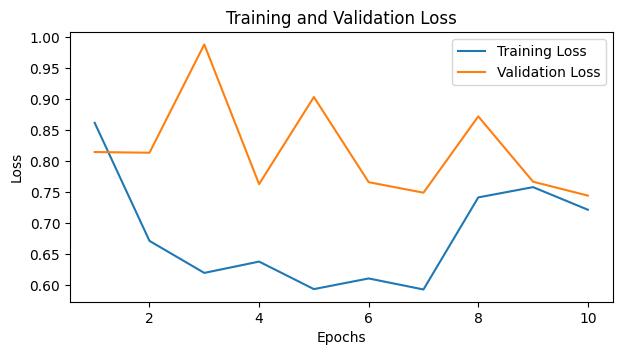

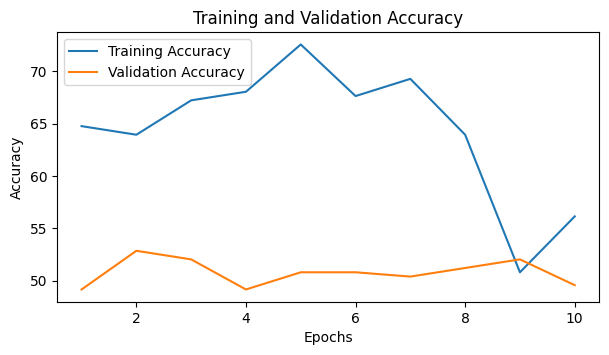

In [166]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## lr = 5e-4

In [167]:
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

lr=5e-4
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [168]:
#
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

# print(device)
# print(model3)

#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

In [169]:
#training and val loop

n_epochs=10
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/10


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 1.0331, training acc: 63.7097, time elapsed: 2.1775


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/10
training loss: 0.8868, training acc: 65.5738, validation loss: 0.8703, validation acc: 51.2295, time elapsed: 6.4641
------------------------------
Epoch 2/10
Step 31/61: training loss: 0.6556, training acc: 70.1613, time elapsed: 8.6627
End of epoch 2/10
training loss: 0.6424, training acc: 68.4426, validation loss: 0.7861, validation acc: 48.7705, time elapsed: 13.2210
------------------------------
Epoch 3/10
Step 31/61: training loss: 0.5731, training acc: 71.7742, time elapsed: 15.6632
End of epoch 3/10
training loss: 0.5424, training acc: 73.3607, validation loss: 1.0266, validation acc: 48.3607, time elapsed: 20.4466
------------------------------
Epoch 4/10
Step 31/61: training loss: 0.6420, training acc: 65.3226, time elapsed: 22.8724
End of epoch 4/10
training loss: 0.5452, training acc: 72.1311, validation loss: 0.9553, validation acc: 47.5410, time elapsed: 27.6193
------------------------------
Epoch 5/10
Step 31/61: training loss: 0.4544, training acc: 7

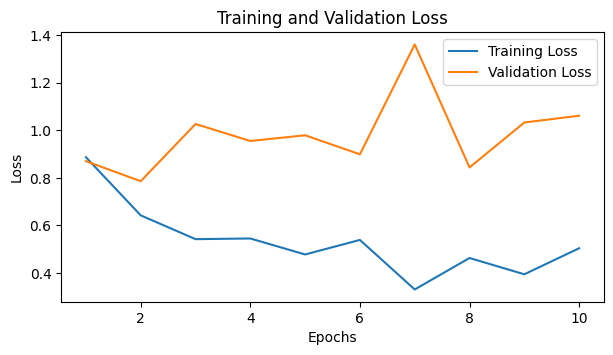

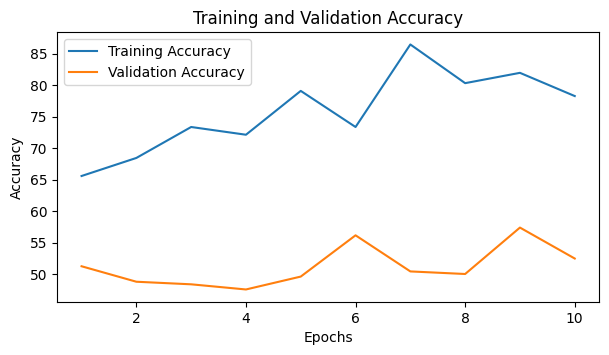

In [170]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## lr = 1e-4

In [171]:
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

lr=1e-4
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [172]:
#
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

# print(device)
# print(model3)

#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

In [173]:
#training and val loop

n_epochs=10
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/10


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 0.5622, training acc: 70.1613, time elapsed: 2.5810


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2929628352.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/10
training loss: 0.4673, training acc: 77.0492, validation loss: 1.0688, validation acc: 52.0492, time elapsed: 7.1523
------------------------------
Epoch 2/10
Step 31/61: training loss: 0.3367, training acc: 85.4839, time elapsed: 9.4223
End of epoch 2/10
training loss: 0.4066, training acc: 81.9672, validation loss: 0.9864, validation acc: 53.2787, time elapsed: 13.7975
------------------------------
Epoch 3/10
Step 31/61: training loss: 0.2654, training acc: 90.3226, time elapsed: 16.1812
End of epoch 3/10
training loss: 0.3286, training acc: 86.4754, validation loss: 1.0696, validation acc: 50.0000, time elapsed: 21.3620
------------------------------
Epoch 4/10
Step 31/61: training loss: 0.2438, training acc: 87.9032, time elapsed: 24.0185
End of epoch 4/10
training loss: 0.3625, training acc: 83.6066, validation loss: 1.0955, validation acc: 50.8197, time elapsed: 28.5934
------------------------------
Epoch 5/10
Step 31/61: training loss: 0.3820, training acc: 8

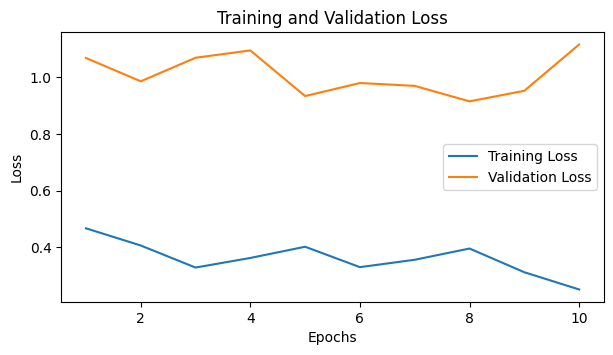

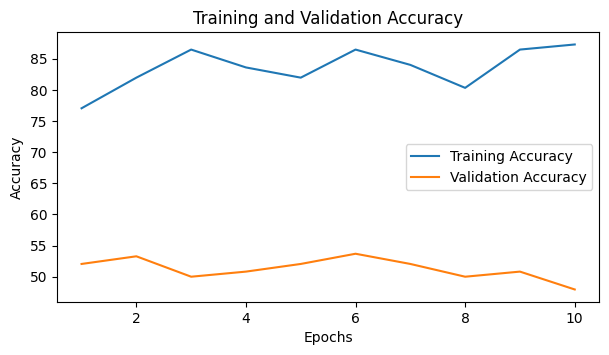

In [174]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## compare plots of diff lr

- accuracies improve faster and overall accuracies better with lower lr
- loss is lower at higher lr, very interesting

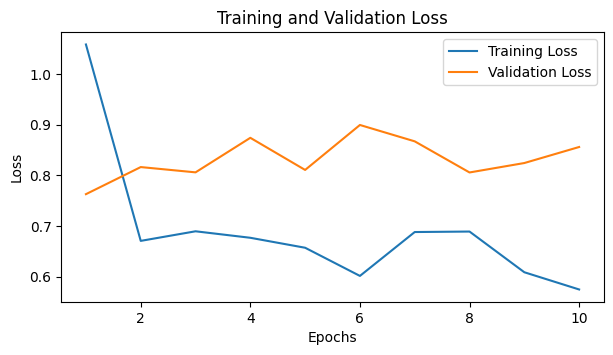

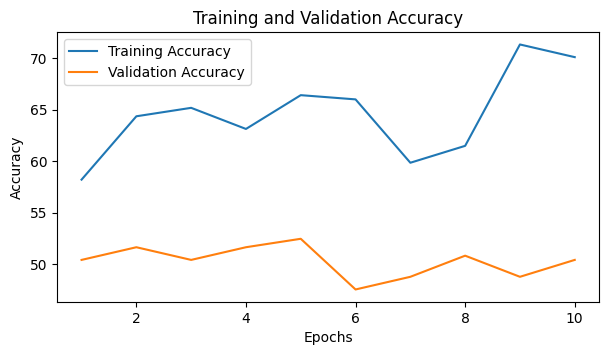

In [162]:
#lr=1e-3
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

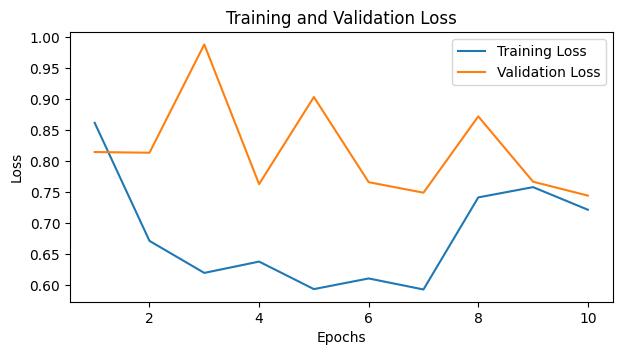

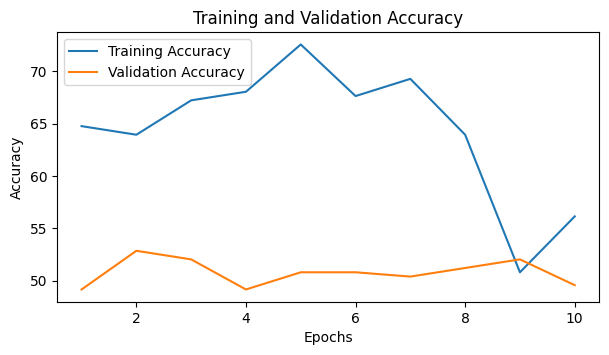

In [166]:
#lr=7.5e-4
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

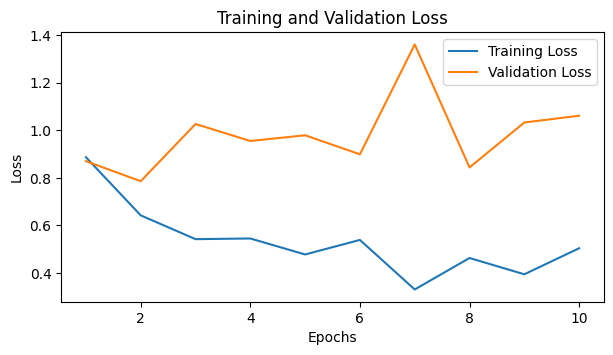

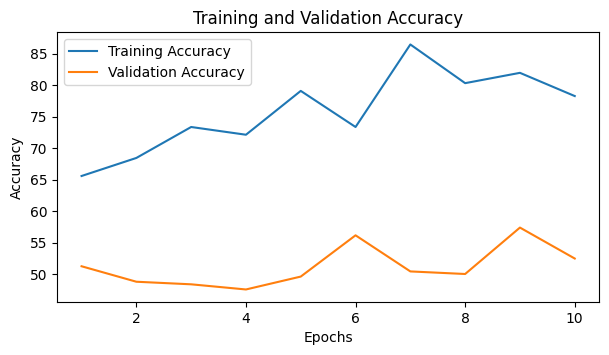

In [170]:
#lr=5e-4
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

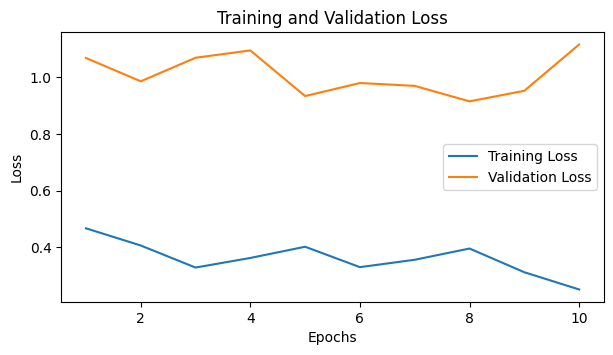

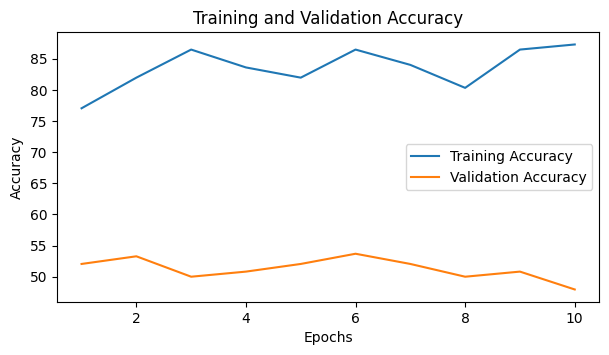

In [174]:
#lr=1e-4
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## try lr 1e-4 for 100 epochs

In [177]:
model3=torchvision.models.resnet18(pretrained=True)
in_features=model3.fc.in_features
model3.fc=nn.Linear(in_features,2)

lr=1e-4
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=lr)

In [178]:
# initialise device and send model to device
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3=model3.to(device)

# print(device)
# print(model3)

#training loop
# to device and reshape labels
# forward pass
# calc loss
# calc acc
# zero weights of optimizer
# calc gradients of loss fn
# update weights of optimizer

#validation loop
# to device
# forward pass
# calc loss 
# calc acc

In [179]:
#training and val loop

n_epochs=100
training_steps_to_print=1

print("########## Start Training loop  ##########")
start_time=time.time()
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}

for epoch in range(n_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{n_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    
    #training loop
    for i,(images,labels) in enumerate(train_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)# for Crosss entropy loss dont need .float()
        # forward pass
        outputs=model3.forward(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        # calc acc
        trg_acc=get_accuracy(softmax_outputs,labels)
        running_training_acc.append(trg_acc)
        # zero weights of optimizer
        optimizer.zero_grad()
        # calc grad of loss fn
        trg_loss.backward()
        # update weights
        optimizer.step()
        
        #print results
        print_divisor=1/(training_steps_to_print+1)
        if i%int(len(train_dl)*print_divisor)==0:
            if i==0 or i==len(train_dl)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dl)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")


    #val loop
    for i,(images,labels) in enumerate(val_dl):
        # to device and reshape labels
#         labels=labels.reshape((-1,1)).float()
        labels = labels.view(-1) 
        images=images.to(device)
        labels=labels.to(device)
        # forward pass
        outputs=model3(images)
        softmax_outputs=nn.Softmax()(outputs)
        # calc loss 
        val_loss=criterion(outputs,labels)
        running_validation_loss.append(val_loss.item())
        # calc acc
        val_acc=get_accuracy(softmax_outputs,labels)
        running_validation_acc.append(val_acc)
        
    #update logs
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{n_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/100


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2429455708.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


Step 31/61: training loss: 0.5511, training acc: 70.1613, time elapsed: 2.3154


C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\2429455708.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)


End of epoch 1/100
training loss: 0.5336, training acc: 71.7213, validation loss: 1.0028, validation acc: 51.2295, time elapsed: 6.4787
------------------------------
Epoch 2/100
Step 31/61: training loss: 0.4387, training acc: 76.6129, time elapsed: 8.6103
End of epoch 2/100
training loss: 0.4487, training acc: 77.4590, validation loss: 0.9341, validation acc: 51.6393, time elapsed: 12.9502
------------------------------
Epoch 3/100
Step 31/61: training loss: 0.4060, training acc: 83.0645, time elapsed: 15.1545
End of epoch 3/100
training loss: 0.4312, training acc: 80.7377, validation loss: 0.8699, validation acc: 44.6721, time elapsed: 19.5109
------------------------------
Epoch 4/100
Step 31/61: training loss: 0.3432, training acc: 87.9032, time elapsed: 21.7208
End of epoch 4/100
training loss: 0.3301, training acc: 86.8852, validation loss: 1.0050, validation acc: 51.2295, time elapsed: 26.0368
------------------------------
Epoch 5/100
Step 31/61: training loss: 0.3908, trainin

Step 31/61: training loss: 0.2482, training acc: 91.9355, time elapsed: 219.6678
End of epoch 33/100
training loss: 0.2187, training acc: 91.8033, validation loss: 0.6739, validation acc: 67.2131, time elapsed: 223.8514
------------------------------
Epoch 34/100
Step 31/61: training loss: 0.0783, training acc: 97.5806, time elapsed: 226.0356
End of epoch 34/100
training loss: 0.1144, training acc: 95.4918, validation loss: 0.7575, validation acc: 63.5246, time elapsed: 230.5877
------------------------------
Epoch 35/100
Step 31/61: training loss: 0.1339, training acc: 95.1613, time elapsed: 232.9836
End of epoch 35/100
training loss: 0.1425, training acc: 94.6721, validation loss: 0.7744, validation acc: 64.3443, time elapsed: 237.7251
------------------------------
Epoch 36/100
Step 31/61: training loss: 0.1334, training acc: 95.9677, time elapsed: 240.1738
End of epoch 36/100
training loss: 0.1109, training acc: 96.3115, validation loss: 0.7161, validation acc: 68.8525, time elapse

End of epoch 64/100
training loss: 0.0655, training acc: 97.5410, validation loss: 0.5155, validation acc: 82.3770, time elapsed: 435.5532
------------------------------
Epoch 65/100
Step 31/61: training loss: 0.0520, training acc: 98.3871, time elapsed: 437.9600
End of epoch 65/100
training loss: 0.0757, training acc: 97.1311, validation loss: 0.4637, validation acc: 83.1967, time elapsed: 442.6274
------------------------------
Epoch 66/100
Step 31/61: training loss: 0.0369, training acc: 100.0000, time elapsed: 444.8072
End of epoch 66/100
training loss: 0.0527, training acc: 98.7705, validation loss: 0.4916, validation acc: 82.3770, time elapsed: 448.9385
------------------------------
Epoch 67/100
Step 31/61: training loss: 0.0397, training acc: 99.1935, time elapsed: 451.0432
End of epoch 67/100
training loss: 0.0878, training acc: 98.3607, validation loss: 0.4359, validation acc: 86.8852, time elapsed: 455.3550
------------------------------
Epoch 68/100
Step 31/61: training los

End of epoch 95/100
training loss: 0.0854, training acc: 97.5410, validation loss: 0.1873, validation acc: 93.0328, time elapsed: 644.9232
------------------------------
Epoch 96/100
Step 31/61: training loss: 0.0193, training acc: 100.0000, time elapsed: 647.3304
End of epoch 96/100
training loss: 0.0128, training acc: 100.0000, validation loss: 0.2714, validation acc: 92.6230, time elapsed: 652.0322
------------------------------
Epoch 97/100
Step 31/61: training loss: 0.0081, training acc: 100.0000, time elapsed: 654.2271
End of epoch 97/100
training loss: 0.0085, training acc: 100.0000, validation loss: 0.3481, validation acc: 89.7541, time elapsed: 658.3162
------------------------------
Epoch 98/100
Step 31/61: training loss: 0.0035, training acc: 100.0000, time elapsed: 660.5137
End of epoch 98/100
training loss: 0.0066, training acc: 100.0000, validation loss: 0.2715, validation acc: 91.3934, time elapsed: 664.6754
------------------------------
Epoch 99/100
Step 31/61: trainin

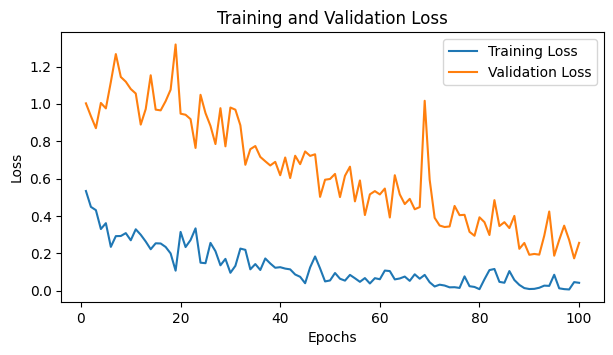

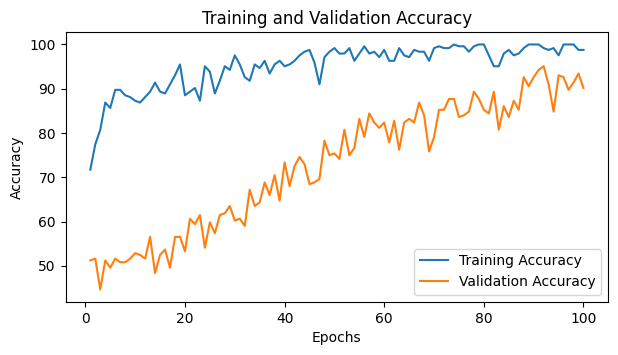

In [180]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, n_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# best_accuracy = 0.0
# # ...

# # Inside the training loop
# # ...
# # Calculate validation accuracy
# validation_accuracy = calculate_accuracy(model1, validation_data)
# # Check if the current model has the highest validation accuracy
# if validation_accuracy > best_accuracy:
#     best_accuracy = validation_accuracy
#     torch.save(model1.state_dict(), save_path)
# # ...

In [ ]:
# # load model
# # Load the saved model
# model_path="ants_bees_resnet18.pth"

# model = CustomModel()  # Instantiate the model
# model.load_state_dict(torch.load(model_path))


If your training and validation loss are decreasing, it indicates that your model is learning and improving its performance. However, if the training loss is plateauing after a certain number of epochs while the validation loss continues to decrease, it suggests that your model may be overfitting the training data.

Overfitting occurs when the model becomes too specialized to the training data and does not generalize well to unseen data, which is indicated by the increasing validation loss or plateauing validation accuracy. To address this issue, you can try the following approaches:

Regularization: Apply regularization techniques such as L1 or L2 regularization to add a penalty term to the loss function, discouraging the model from overemphasizing certain features or parameters. This can help prevent overfitting and improve generalization.

Dropout: Implement dropout layers in your model, which randomly disable a portion of the neurons during training. Dropout helps prevent the model from relying too heavily on specific neurons and encourages the learning of more robust and generalized features.

Data augmentation: Increase the diversity and variability of your training data by applying data augmentation techniques. This can involve random transformations such as rotation, scaling, cropping, or flipping of the training images. Data augmentation provides the model with more variations to learn from and can improve its ability to generalize.

Early stopping: Monitor the validation loss or accuracy during training and apply early stopping to prevent overfitting. If the validation loss starts increasing or the validation accuracy plateaus for a certain number of epochs, you can stop the training process to avoid overfitting. You can save the model parameters at the point of the lowest validation loss or highest validation accuracy.

Model architecture modifications: Consider adjusting the complexity of your model. A complex model may have a higher risk of overfitting, so you can try reducing the number of layers, the number of hidden units, or applying other architectural modifications to simplify the model.

Remember to evaluate your model's performance on a separate test set after implementing these approaches to ensure that it generalizes well to unseen data.

## next steps

In [139]:
# save model
save_path="ants_bees_cnn_model2.pth"
torch.save(model2.state_dict(),save_path)

The line torch.save(model1.state_dict(), save_path) saves the state dictionary of the model to the specified save_path. The state dictionary includes all the learnable parameters of the model.

By default, this line of code saves the latest state of the model at the time it is called. If you want to save the best model based on a certain criterion (e.g., highest validation accuracy), you need to implement the logic for tracking the best model and save the state dictionary accordingly.

Here's an example 

In [ ]:
# best_accuracy = 0.0
# # ...

# # Inside the training loop
# # ...
# # Calculate validation accuracy
# validation_accuracy = calculate_accuracy(model1, validation_data)
# # Check if the current model has the highest validation accuracy
# if validation_accuracy > best_accuracy:
#     best_accuracy = validation_accuracy
#     torch.save(model1.state_dict(), save_path)
# # ...

In [ ]:
# # load model
# # Load the saved model
# model_path="ants_bees_resnet18.pth"

# model = CustomModel()  # Instantiate the model
# model.load_state_dict(torch.load(model_path))

C:\Users\Palaash.HPZ\AppData\Local\Temp\ipykernel_53344\1176354142.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs=nn.Softmax()(outputs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


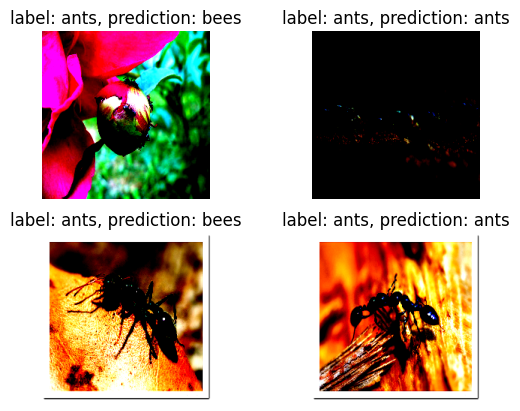

In [183]:
# make predictions

index=9

class_decoder = train_data=Ants_Bees_Dataset(train_path,tfms=train_tfms()).class_decoder
for i,(images,labels) in enumerate(val_dl):
    # to device and reshape labels
    labels=labels.reshape((-1,1)).float()
    images=images.to(device)
    labels=labels.to(device)
    # forward pass
    outputs=model3(images)
    softmax_outputs=nn.Softmax()(outputs)
    _, predicted_classes = torch.max(softmax_outputs, dim=1) #dim=1 check for max in a row, dim=0 check for max in a col
    predicted_class=[class_decoder[x.item()] for x in predicted_classes.cpu()]
    gt_class=[class_decoder[x.item()] for x in labels.cpu()]
    if i==index:
        break


for i in range(len(images)):
    plt.subplot(len(images)//2,len(images)//2,i+1)
    img=images[i]
    img=img.cpu().numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"label: {gt_class[i]}, prediction: {predicted_class[i]}")
    plt.axis("off")
    
    
plt.show()

# others

In [43]:
from fastai.vision.all import *

In [50]:
dls = DataLoaders(train_dataloader, val_dataloader)
learn = Learner(dls, resnet18,criterion )
learn.fit(1)

In [101]:
model2(images)

tensor([[-0.0758],
        [-0.1250],
        [-0.1079],
        [-0.1394]], grad_fn=<AddmmBackward0>)

In [102]:
nn.Sigmoid()(model2(images))

tensor([[0.4811],
        [0.4688],
        [0.4731],
        [0.4652]], grad_fn=<SigmoidBackward0>)

In [106]:
model2(images)

tensor([[-0.0898,  0.0783],
        [-0.1167,  0.1167],
        [-0.1012,  0.0923],
        [-0.1716,  0.1014]], grad_fn=<AddmmBackward0>)

In [109]:
outputs=nn.Sigmoid()(model2(images))
outputs

tensor([[0.4776, 0.5196],
        [0.4709, 0.5291],
        [0.4747, 0.5231],
        [0.4572, 0.5253]], grad_fn=<SigmoidBackward0>)

In [108]:
labels

tensor([1, 1, 1, 1])

In [115]:
test=torch.rand((4,2))
test

tensor([[0.9142, 0.7159],
        [0.8674, 0.3954],
        [0.0128, 0.8700],
        [0.3303, 0.9841]])

In [119]:
torch.max(test, dim=0) #check for max in column

torch.return_types.max(
values=tensor([0.9142, 0.9841]),
indices=tensor([0, 3]))

In [120]:
torch.max(test, dim=1) #check for max in row

torch.return_types.max(
values=tensor([0.9142, 0.8674, 0.8700, 0.9841]),
indices=tensor([0, 0, 1, 1]))

In [112]:
torch.max(outputs, dim=0)

torch.return_types.max(
values=tensor([0.4776, 0.5291], grad_fn=<MaxBackward0>),
indices=tensor([0, 1]))